<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#data-loading-and-train-test-split" data-toc-modified-id="data-loading-and-train-test-split-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>data loading and train test split</a></span></li><li><span><a href="#Composition-model" data-toc-modified-id="Composition-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Composition model</a></span><ul class="toc-item"><li><span><a href="#default-model-with-linear-regression" data-toc-modified-id="default-model-with-linear-regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>default model with linear regression</a></span></li><li><span><a href="#Try-different-regression-models-(without-parameter-optimization)" data-toc-modified-id="Try-different-regression-models-(without-parameter-optimization)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Try different regression models (without parameter optimization)</a></span></li><li><span><a href="#test-case:-Si,-Ge,-Si49Ge51" data-toc-modified-id="test-case:-Si,-Ge,-Si49Ge51-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>test case: Si, Ge, Si49Ge51</a></span></li></ul></li><li><span><a href="#Structure-model" data-toc-modified-id="Structure-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Structure model</a></span><ul class="toc-item"><li><span><a href="#default" data-toc-modified-id="default-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>default</a></span></li><li><span><a href="#Try-different-regression-models-(without-parameter-optimization)" data-toc-modified-id="Try-different-regression-models-(without-parameter-optimization)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Try different regression models (without parameter optimization)</a></span></li><li><span><a href="#test-case:-Si,-Ge,-Si49Ge51" data-toc-modified-id="test-case:-Si,-Ge,-Si49Ge51-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>test case: Si, Ge, Si49Ge51</a></span></li></ul></li></ul></div>

In [1]:
from monty.serialization import loadfn
from pymatgen.core import Structure
from rewotesMLpredictor.featurizer import CompositionFeaturizer, StructureFeaturizer
from rewotesMLpredictor.predictor import Predictor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Lasso, SGDRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# data loading and train test split

In [2]:
data_MP_Bandgap = loadfn("MP_789_bandgap.json")

In [3]:
data_MP_Bandgap_train, data_MP_Bandgap_test = train_test_split(
    data_MP_Bandgap, test_size=0.1, train_size=0.9, random_state=42, shuffle=True)
print(f"We have {len(data_MP_Bandgap_train)} training data and {len(data_MP_Bandgap_test)} test data.")


We have 710 training data and 79 test data.


In [4]:
structures_train = [d['structure'] for d in data_MP_Bandgap_train]
compositions_train = [s.composition for s in structures_train]
bandgap_MP_train = [d['band_gap'] for d in data_MP_Bandgap_train]

structures_test = [d['structure'] for d in data_MP_Bandgap_test]
compositions_test = [s.composition for s in structures_test]
bandgap_MP_test = [d['band_gap'] for d in data_MP_Bandgap_test]

# Composition model

## default model with linear regression

In [5]:
predictor = Predictor()

In [6]:
%%time
predictor.fit(structures_train, bandgap_MP_train)

CPU times: user 19.2 s, sys: 3.04 s, total: 22.3 s
Wall time: 16.1 s


Predictor()

In [7]:
%%time
bandgap_MP_predicted_test = predictor.predict(structures_test)
bandgap_MP_predicted_train = predictor.predict(structures_train)

CPU times: user 20.8 s, sys: 2.83 s, total: 23.6 s
Wall time: 17.3 s


In [8]:
def parity_plot(x, y, label=None):
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)
    plt.plot(x, y, "*", label=f"{label}MAE={mae:.2f}eV, r2={r2:.2f}", alpha=0.5)
    plt.xlabel("Band gap in MP (eV)", size=18)
    plt.ylabel("ML-predicted band gap (eV)", size=18)
    xy_max, xy_min = np.max([x,y])+1, np.min([x,y])-1
    plt.ylim(xy_min, xy_max)
    plt.xlim(xy_min, xy_max)

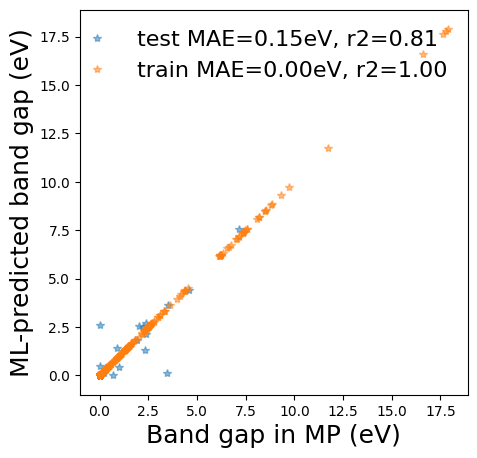

In [9]:
plt.figure(figsize=(5,5))
parity_plot(bandgap_MP_test, bandgap_MP_predicted_test, label="test ")
parity_plot(bandgap_MP_train, bandgap_MP_predicted_train, label="train ")
plt.legend(frameon=False, fontsize=16)

## Try different regression models (without parameter optimization)

<font color="red">These tests are only for POC, where cross validation and parameter optimization are skipped.</font>

In [11]:
regression_models = [BayesianRidge(), HuberRegressor(), Lasso(), SGDRegressor(), 
                     LinearSVR(), NuSVR(), DecisionTreeRegressor()]


In [12]:
%%time

predictions_train, predictions_test, predictors, MAEs, r2s = [], [], [], [], []
for model in regression_models:
    t0 = time.time()
    predictor = Predictor(model=model)
    predictor.fit(compositions_train, bandgap_MP_train)
    predictions_train.append(predictor.predict(compositions_train))
    predictions_test.append(predictor.predict(compositions_test))
    predictors.append(predictor)
    mae = mean_absolute_error(bandgap_MP_train, predictions_train[-1]), mean_absolute_error(bandgap_MP_test, predictions_test[-1])
    r2 = r2_score(bandgap_MP_train, predictions_train[-1]), r2_score(bandgap_MP_test, predictions_test[-1])
    MAEs.append(mae)
    r2s.append(r2)
    t1 = time.time()
    print(f"\nUsed {t1-t0}s to fit and predict with {model}.",
          f" MAE={mae}, r2={r2} for training and test.")


Used 92.69194388389587s to fit and predict with BayesianRidge().  MAE=(1.0343400119315826, 0.906200085773074), r2=(0.3564487054642973, 0.04149132197153782) for training and test.

Used 91.0976619720459s to fit and predict with HuberRegressor().  MAE=(0.7372392486671339, 0.47255534040635433), r2=(-0.03254818393857151, -0.03529054268153198) for training and test.

Used 97.7992217540741s to fit and predict with Lasso().  MAE=(1.170834173378298, 0.9267929220894995), r2=(0.0, -0.05886777501435292) for training and test.

Used 98.1725959777832s to fit and predict with SGDRegressor().  MAE=(1.0199571334533195, 0.8665224823330875), r2=(0.32158355155824025, 0.03541707675613259) for training and test.


/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Used 108.9315869808197s to fit and predict with LinearSVR().  MAE=(0.7324661971769035, 0.4459507537995644), r2=(-0.10299677391558171, -0.11956662973253152) for training and test.

Used 117.87356877326965s to fit and predict with NuSVR().  MAE=(0.5163904684359325, 0.33617895475398685), r2=(0.37509899434698113, 0.5100533583596244) for training and test.

Used 120.03790378570557s to fit and predict with DecisionTreeRegressor().  MAE=(0.37025286517420947, 0.2976418371773046), r2=(0.8391542622341734, 0.6918224875377497) for training and test.
CPU times: user 5.76 s, sys: 6.86 s, total: 12.6 s
Wall time: 12min 6s


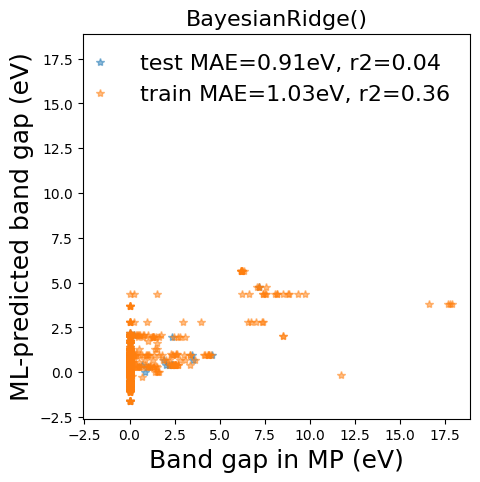

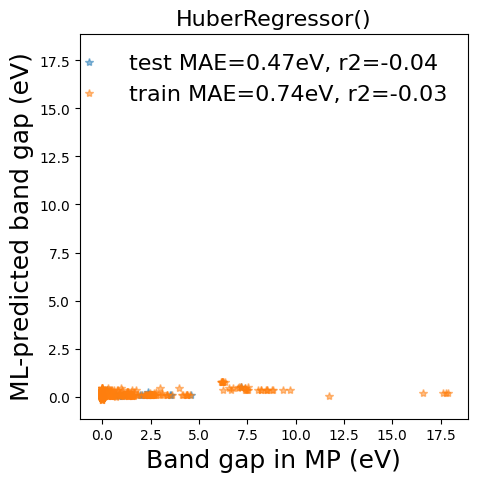

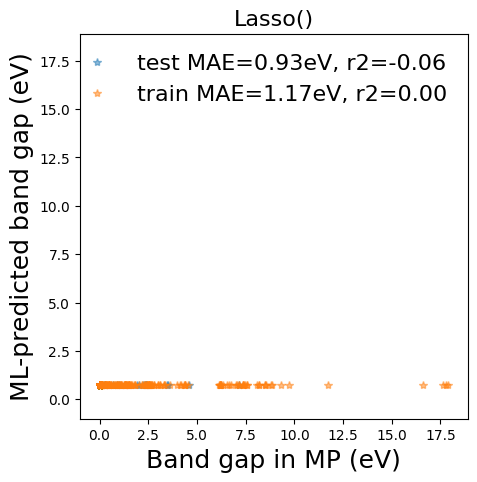

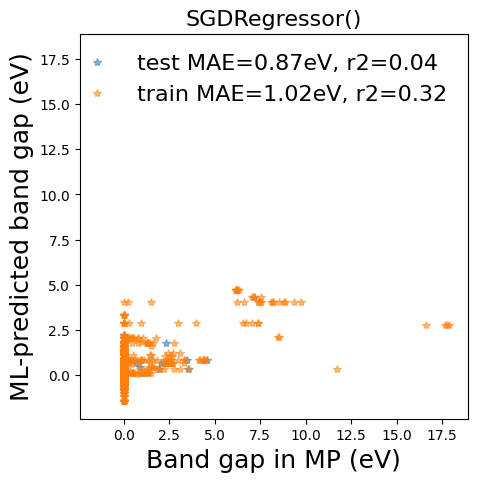

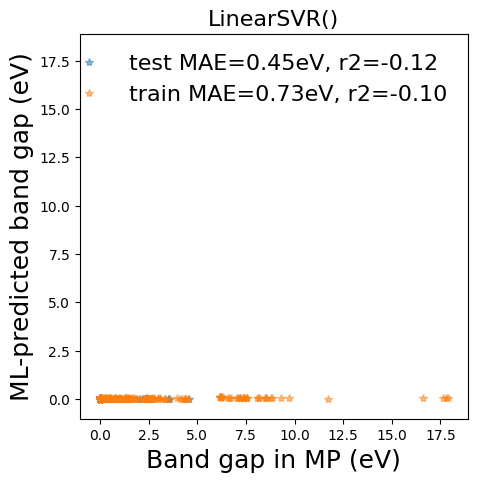

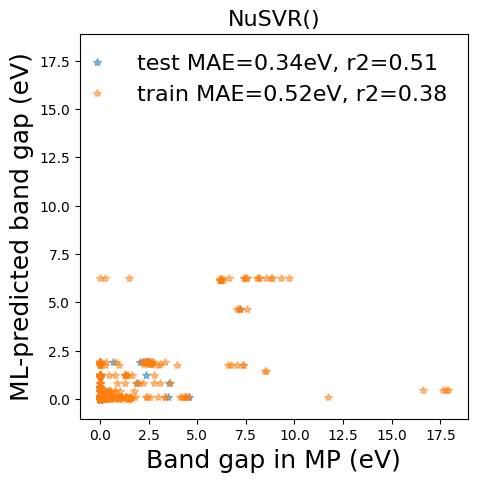

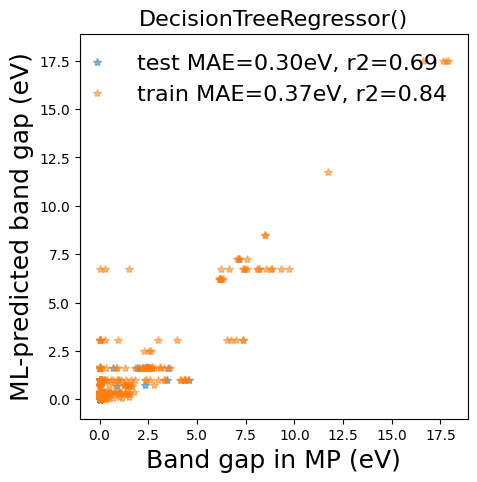

In [13]:
for i, prediction_train in enumerate(predictions_train):
    plt.figure(figsize=(5,5))
    parity_plot(bandgap_MP_test, predictions_test[i], label="test ")
    parity_plot(bandgap_MP_train, prediction_train, label="train ")
    plt.legend(frameon=False, fontsize=16)
    plt.title(regression_models[i], size=16)

## test case: Si, Ge, Si49Ge51

In [14]:
compositions = ["Si", "Ge","Ge10", "SiGe"]
for composition in compositions:
    print(f"Predicted band gap is {predictors[-1].predict([composition])[0]:.2f}eV for {composition}")

Predicted band gap is 0.35eV for Si
Predicted band gap is 0.09eV for Ge
Predicted band gap is 0.09eV for Ge10
Predicted band gap is 0.35eV for SiGe


# Structure model

## default 

In [15]:
predictor = Predictor(featurizer=StructureFeaturizer())

In [16]:
SF = StructureFeaturizer()

In [17]:
%%time
predictor.fit(structures_train, bandgap_MP_train)

CPU times: user 20.2 s, sys: 2.47 s, total: 22.7 s
Wall time: 17.2 s


Predictor(featurizer=StructureFeaturizer(featurizers=[M3GNetStructure()]))

In [18]:
%%time
bandgap_MP_predicted_test = predictor.predict(structures_test)
bandgap_MP_predicted_train = predictor.predict(structures_train)

CPU times: user 23.5 s, sys: 2.95 s, total: 26.5 s
Wall time: 17.8 s


In [19]:
def parity_plot(x, y, label=None):
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)
    plt.plot(x, y, "*", label=f"{label}MAE={mae:.2f}eV, r2={r2:.2f}", alpha=0.5)
    plt.xlabel("Band gap in MP (eV)", size=18)
    plt.ylabel("ML-predicted band gap (eV)", size=18)
    xy_max, xy_min = np.max([x,y])+1, np.min([x,y])-1
    plt.ylim(xy_min, xy_max)
    plt.xlim(xy_min, xy_max)

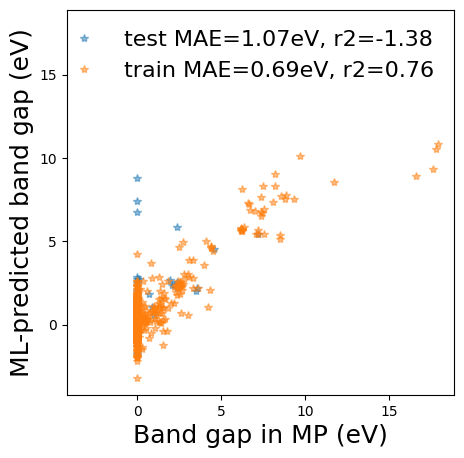

In [20]:
plt.figure(figsize=(5,5))
parity_plot(bandgap_MP_test, bandgap_MP_predicted_test, label="test ")
parity_plot(bandgap_MP_train, bandgap_MP_predicted_train, label="train ")
plt.legend(frameon=False, fontsize=16)

## Try different regression models (without parameter optimization)

<font color="red">These tests are only for POC, where cross validation and parameter optimization are skipped.</font>

In [21]:
from rewotesMLpredictor.featurizer import MATMINER_ELEMENT_PRESETS
from sklearn.linear_model import BayesianRidge, HuberRegressor, Lasso, SGDRegressor
from sklearn.svm import LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
import time

In [22]:
regression_models = [BayesianRidge(), HuberRegressor(), Lasso(), SGDRegressor(), 
                     LinearSVR(), NuSVR(), DecisionTreeRegressor()]


In [23]:
%%time
predictions_train, predictions_test, predictors, MAEs, r2s = [], [], [], [], []
for model in regression_models:
    t0 = time.time()
    predictor = Predictor(featurizer=StructureFeaturizer(), model=model)
    predictor.fit(structures_train, bandgap_MP_train)
    predictions_train.append(predictor.predict(structures_train))
    predictions_test.append(predictor.predict(structures_test))
    predictors.append(predictor)
    mae = mean_absolute_error(bandgap_MP_train, predictions_train[-1]), mean_absolute_error(bandgap_MP_test, predictions_test[-1])
    r2 = r2_score(bandgap_MP_train, predictions_train[-1]), r2_score(bandgap_MP_test, predictions_test[-1])
    MAEs.append(mae)
    r2s.append(r2)
    t1 = time.time()
    print(f"\nUsed {t1-t0}s to fit and predict with {model}.",
          f" MAE={mae}, r2={r2} for training and test.")


Used 33.330888986587524s to fit and predict with BayesianRidge().  MAE=(0.7961006331943244, 0.9578369137065228), r2=(0.47567269634324116, -0.9476993449937678) for training and test.


/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



Used 37.080801010131836s to fit and predict with HuberRegressor().  MAE=(0.6565132439947838, 0.5603979508834313), r2=(0.31835476708767974, 0.18121436178237982) for training and test.



Used 39.98725199699402s to fit and predict with Lasso().  MAE=(1.170834173378298, 0.9267929220894995), r2=(0.0, -0.05886777501435292) for training and test.



Used 37.38307976722717s to fit and predict with SGDRegressor().  MAE=(0.8719551456566965, 0.9386809118541182), r2=(0.4016984058209665, -0.5458986202295855) for training and test.


/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Used 36.48697113990784s to fit and predict with LinearSVR().  MAE=(0.6698594488671663, 0.5151593374888204), r2=(0.197528669631852, 0.17525497548521807) for training and test.



Used 34.51852893829346s to fit and predict with NuSVR().  MAE=(0.5284472647678449, 0.45883792051632366), r2=(0.32899690415312643, 0.245067266306781) for training and test.



Used 36.29698991775513s to fit and predict with DecisionTreeRegressor().  MAE=(4.1697881087932823e-19, 0.16244177215189876), r2=(1.0, 0.7994520083222996) for training and test.
CPU times: user 5min 8s, sys: 44.7 s, total: 5min 52s
Wall time: 4min 15s


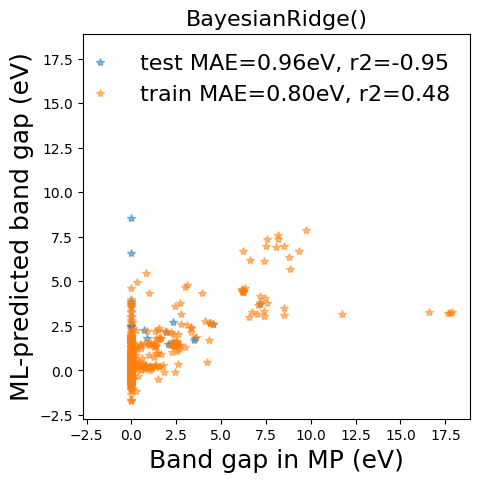

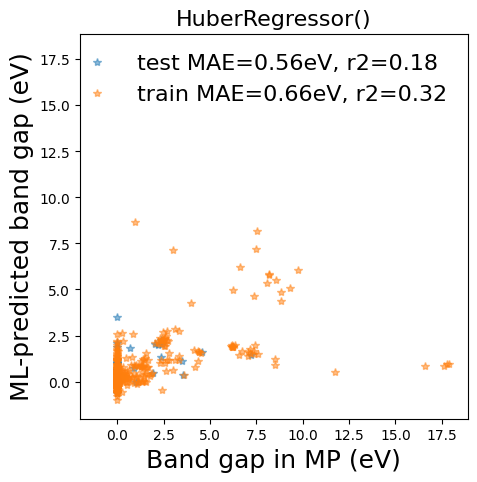

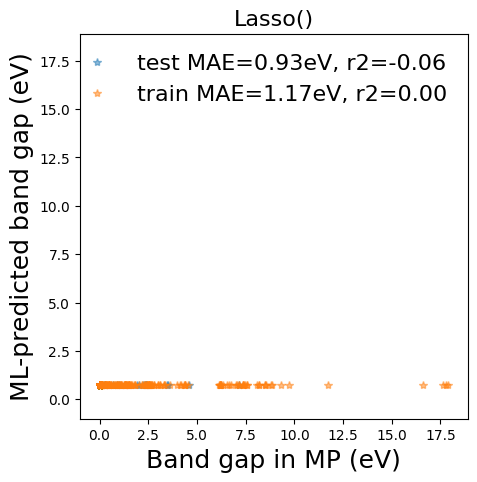

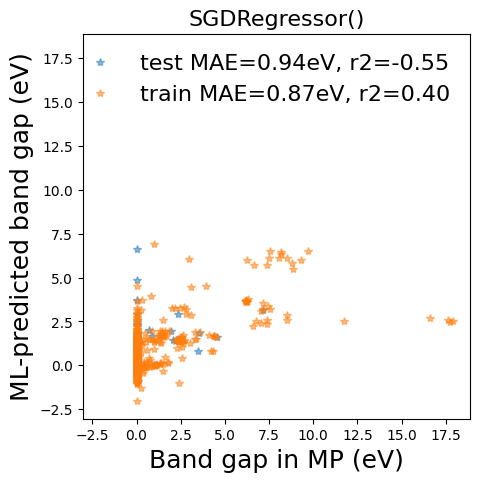

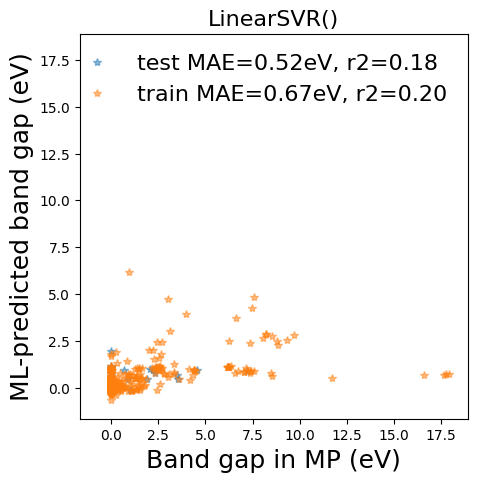

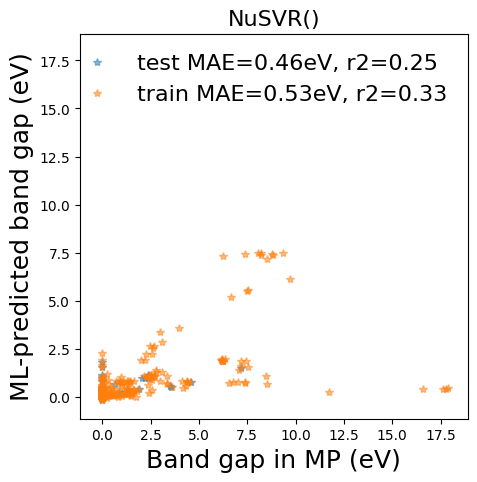

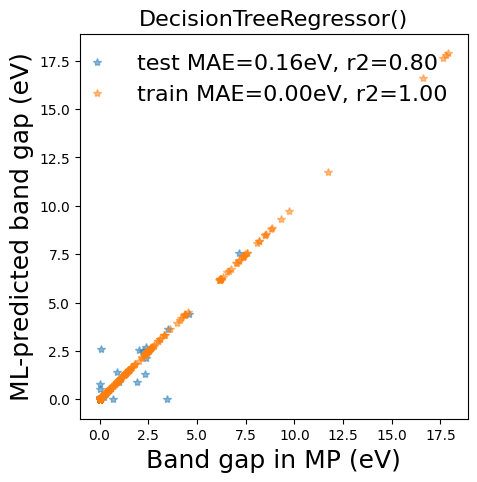

In [24]:
for i, prediction_train in enumerate(predictions_train):
    plt.figure(figsize=(5,5))
    parity_plot(bandgap_MP_test, predictions_test[i], label="test ")
    parity_plot(bandgap_MP_train, prediction_train, label="train ")
    plt.legend(frameon=False, fontsize=16)
    plt.title(regression_models[i], size=16)